In [106]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm

In [107]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [108]:
id = '1v00UIULqUbCnofIrkd7TBbnB5fvunIgJ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Portfolio.xlsx')  

In [109]:
#We import the sheets of our Excel dataset
df_portfolio = pd.read_excel (r'Portfolio.xlsx',sheet_name='Portfolio')
df_param = pd.read_excel (r'Portfolio.xlsx',sheet_name='Param')
df_sector = pd.read_excel (r'Portfolio.xlsx',sheet_name='Sector')
df_rating = pd.read_excel (r'Portfolio.xlsx',sheet_name='Rating')

df_portfolio=df_portfolio.set_index('Id')
df_sector=df_sector.set_index('Sector')
df_rating=df_rating.set_index('Rating')

#We put the parameters in lists and constants
rhos=[]
for i in range(len(df_sector.values)):
  rhos.append(df_sector.values[i][0])

N_simu=round(df_param['Nsimul'].mean())
rho=df_param['GlobalCorrelation'].mean()
IC=df_param['IC'].mean()

N_companies=len(df_portfolio) #We count the number of companies

strike=7
size=2
PA=strike + size
total_exposure=df_portfolio['Exposure'].sum()


df_portfolio.head(10)

,Exposure,Rating,LGD,Sector
Id,,,,
1,1894,1,0.59,2
2,1095,4,0.44,1
3,1627,6,0.69,1
4,1914,10,0.57,3
5,1662,8,0.46,4
6,1899,10,0.51,1
7,1747,9,0.52,1
8,1595,3,0.41,5
9,1229,7,0.42,5


#**Addition of the defect barriers**

In [110]:
#We merge the dataframes into one final dataframe
df_portfolio = df_portfolio.merge(df_rating,how='left', on='Rating',sort=False)

df_portfolio

,Exposure,Rating,LGD,Sector,1Y,3Y,5Y
0,1894,1,0.59,2,0.001,0.0015,0.00225
1,1095,4,0.44,1,0.016,0.0240,0.03600
2,1627,6,0.69,1,0.036,0.0540,0.08100
3,1914,10,0.57,3,0.100,0.1500,0.22500
4,1662,8,0.46,4,0.064,0.0960,0.14400
...,...,...,...,...,...,...,...
95,1841,3,0.52,2,0.009,0.0135,0.02025
96,1779,2,0.40,4,0.004,0.0060,0.00900
97,1809,10,0.61,1,0.100,0.1500,0.22500
98,1737,7,0.46,3,0.049,0.0735,0.11025


In [111]:
df_portfolio['Barriers 1Y']=pd.DataFrame(norm.ppf(df_portfolio['1Y']))
df_portfolio['Barriers 3Y']=pd.DataFrame(norm.ppf(df_portfolio['3Y']))
df_portfolio['Barriers 5Y']=pd.DataFrame(norm.ppf(df_portfolio['5Y']))

df_portfolio

,Exposure,Rating,LGD,Sector,1Y,3Y,5Y,Barriers 1Y,Barriers 3Y,Barriers 5Y
0,1894,1,0.59,2,0.001,0.0015,0.00225,-3.090232,-2.967738,-2.840804
1,1095,4,0.44,1,0.016,0.0240,0.03600,-2.144411,-1.977368,-1.799118
2,1627,6,0.69,1,0.036,0.0540,0.08100,-1.799118,-1.607248,-1.398377
3,1914,10,0.57,3,0.100,0.1500,0.22500,-1.281552,-1.036433,-0.755415
4,1662,8,0.46,4,0.064,0.0960,0.14400,-1.522036,-1.304685,-1.062519
...,...,...,...,...,...,...,...,...,...,...
95,1841,3,0.52,2,0.009,0.0135,0.02025,-2.365618,-2.211518,-2.048613
96,1779,2,0.40,4,0.004,0.0060,0.00900,-2.652070,-2.512144,-2.365618
97,1809,10,0.61,1,0.100,0.1500,0.22500,-1.281552,-1.036433,-0.755415
98,1737,7,0.46,3,0.049,0.0735,0.11025,-1.654628,-1.450210,-1.225200


# **Monte carlo simulation**

In [112]:
def monte_carlo(N_simu,N_companies):
  #We simulate 106 times 10 000 values of a N(0,1) normal distribution.
  simu_mc=np.random.randn(N_simu,N_companies+6)
  #We convert the resulting array into a dataframe
  simu_mc = pd.DataFrame(simu_mc,
                   columns=['X', 'X1', 'X2','X3','X4','X5']+['E'+str(i) for i in range(1,N_companies+1)])
  return simu_mc

simu_mc=monte_carlo(N_simu,N_companies)
simu_mc.head()

,X,X1,X2,X3,X4,X5,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27,E28,E29,E30,E31,E32,E33,E34,...,E61,E62,E63,E64,E65,E66,E67,E68,E69,E70,E71,E72,E73,E74,E75,E76,E77,E78,E79,E80,E81,E82,E83,E84,E85,E86,E87,E88,E89,E90,E91,E92,E93,E94,E95,E96,E97,E98,E99,E100
0,-1.348122,-0.865214,-0.485789,0.582812,1.357573,-0.852120,-0.279301,-0.447623,-0.156060,0.016838,1.479632,0.762903,0.001280,1.618245,0.067107,-1.426943,-1.412986,-0.352027,-0.672217,-1.280773,0.956575,-0.692678,0.401239,0.159986,0.568724,-0.950146,-0.171858,-1.413888,0.994166,-2.851976,-0.408706,-0.667840,1.144238,0.491148,-0.736384,-1.190928,0.736925,-0.028219,0.670937,-0.337045,...,0.443269,0.374903,0.821082,0.090990,-0.041665,0.953140,-0.628546,-0.556618,0.414216,0.138780,-0.563794,-0.096391,0.146472,-1.142438,0.529868,-1.258724,-0.354619,1.610648,0.282107,-1.190118,-1.325980,-0.178606,-3.884325,1.053858,-0.442339,-0.840629,1.561772,1.186952,0.692360,-1.268270,0.097731,-1.217188,-0.782035,0.006271,1.778116,1.171725,-0.589647,-0.488785,0.892713,0.544949
1,0.494444,-1.251993,-0.484428,0.146573,0.520725,-0.701026,-0.072154,0.070476,-1.485132,-0.121492,-0.644178,-0.370471,-0.233509,0.973851,-0.656188,-1.548667,1.008851,0.466280,0.655478,-0.715661,1.655654,-0.046157,-1.538902,0.972681,0.754423,-0.806299,1.415890,0.636228,-0.095829,-0.379861,-0.685291,1.124312,0.759771,-0.213731,0.221571,1.129664,-0.313765,-0.430833,-1.520811,0.377307,...,-1.452736,0.346272,0.888382,-0.900673,0.495887,0.347667,-0.329803,-0.436028,0.500426,-0.794424,0.469524,0.307890,-2.751847,-0.005133,-0.488868,0.028994,0.289205,0.487302,-0.369190,-1.650496,-1.067738,2.092891,0.567193,1.155896,0.165625,-0.760405,-0.799569,0.386536,-2.179029,-1.416943,-0.218285,-0.751044,0.135450,-1.199278,0.027834,0.035162,0.322839,-1.660678,1.033564,-0.785522
2,0.034467,0.548230,-1.071946,-1.383252,-0.558252,-0.259609,-0.492478,0.279313,0.332635,0.095516,1.349951,0.124888,-0.133292,0.223799,0.486362,-1.500447,1.161183,0.058638,-0.493573,-0.404076,1.423945,0.465421,0.061797,0.500373,0.095754,-0.972568,0.897624,1.585567,-0.580049,2.540934,-1.407425,1.395442,0.411095,1.676616,-1.135135,0.960654,0.986130,-0.151517,1.832026,-0.053800,...,1.760110,-1.881790,-0.576175,0.094022,-1.334648,1.067109,1.306226,1.560710,0.189828,-0.312517,0.280655,-1.514601,0.924620,0.100430,-0.535748,0.636836,-0.569426,-1.116020,-0.917867,-0.286331,-1.822184,1.042937,0.849448,-0.859286,-0.578064,-0.193071,0.220992,-1.282151,-1.126964,1.369217,-0.887770,1.661766,1.753727,0.001964,0.125298,0.480291,-0.315208,-1.704779,0.188957,-1.927176
3,2.105433,-0.219454,1.547955,-0.204400,0.229794,-1.336769,-0.475159,0.607639,0.416553,0.487262,0.797358,-0.233350,-0.414127,-1.405333,-2.767693,-0.695517,-0.204893,0.537384,0.903906,-1.070988,0.491173,-0.699833,0.077235,-0.746708,-0.335000,0.342138,1.603708,-0.903173,-0.855806,0.212913,-0.426068,0.155747,0.389355,-0.167569,-0.841163,-0.104077,0.933272,-1.357008,-0.347631,-0.779580,...,-0.545841,-0.126897,-0.014333,-0.257079,-1.477856,-0.318679,0.214981,0.003493,0.469803,-0.194653,0.022460,3.161332,-1.372426,-0.390058,-1.668559,0.942091,0.614374,0.829006,0.830189,-1.378590,-0.616977,-1.101345,0.304409,-0.526114,1.057746,0.752585,-1.102613,-1.002983,1.374117,-0.766904,0.560322,1.991370,-1.169894,-0.435043,0.399635,1.235478,-0.319273,-0.251486,-2.262947,-0.087087
4,0.221130,1.501112,0.156160,-0.411320,1.921159,0.966620,0.112673,-0.379363,0.317761,-0.021478,0.360160,-1.331000,-0.561510,-2.214324,1.493623,-0.604202,-0.196655,-0.584875,-0.222068,0.486436,-1.030017,0.355590,-0.774649,-0.539123,0.095144,0.112664,0.232280,-0.312702,-0.469982,1.763232,0.474982,0.127133,0.426486,0.000814,0.287123,-1.655247,-0.377480,0.302476,0.025700,-0.244647,...,-1.432289,-0.591776,-1.214180,-0.237094,-1.816456,-1.138750,-0.622078,0.302104,0.255688,1.582820,0.847283,-0.040406,1.175403,1.718955,1.079813,-0.318964,1.404033,0.386994,0.194368,0.880861,1.695695,1.329391,-0.627870,-0.385933,-0.786381,

#**Calculation of the diffusion**

In [113]:
#We copy the E1,...,E100 columns of our previous dataframe to simplify the calculations...
def calculate_zi(simu_mc,rho,rhos,N_simu,N_companies):
  simu_zi=pd.DataFrame(index=range(N_simu))
  A=simu_mc[['E'+ str(j) for j in range(1,N_companies+1)]]
  for i, column in enumerate(A):
    sector=df_portfolio['Sector'][i]
    simu_zi['Z'+str(i+1)]=np.sqrt(rho)*simu_mc['X']+np.sqrt(rhos[sector-1]-rho)*simu_mc['X'+str(sector)]+np.sqrt(1-rhos[sector-1])*A[column] # Z_i=sqrt(𝜌)*𝑋 + sqrt(𝜌_s − 𝜌)*𝑋_s + sqrt(1 − 𝜌_s)*𝜀_i
  return simu_zi

simu_zi=calculate_zi(simu_mc,rho,rhos,N_simu,N_companies)

simu_zi

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,Z38,Z39,Z40,...,Z61,Z62,Z63,Z64,Z65,Z66,Z67,Z68,Z69,Z70,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80,Z81,Z82,Z83,Z84,Z85,Z86,Z87,Z88,Z89,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99,Z100
0,-0.900055,-1.139628,-0.883782,-0.315035,1.251923,-0.077395,-0.745717,0.744645,-0.642735,-1.979054,-1.633268,-0.406715,-0.950313,-1.870714,0.152829,-0.715188,0.039365,-0.537810,-0.200756,-0.948335,-0.243566,-1.987522,0.150072,-3.249439,-1.068315,-1.300091,0.948210,-0.263461,-1.361399,-1.166373,-0.062054,-0.113495,-0.116469,-0.947673,-3.116111,-0.856133,-1.438314,-2.521931,-0.894441,0.089931,...,0.313456,0.015084,0.655580,-0.005547,-0.368972,0.548193,-1.188050,-0.591981,-0.383368,-0.202611,-0.598479,-0.831423,-0.548954,-1.122463,-0.228829,-1.707709,-0.962164,0.666497,-0.450433,-1.791164,-1.910383,-0.817021,-3.605348,0.199295,-1.134991,-0.849164,0.618132,0.294706,-0.139297,-1.236409,-0.615344,-1.190152,-1.402230,-0.697148,0.813450,0.296491,-0.621890,-1.175747,0.492481,-0.220362
1,-0.117504,-0.207872,-1.572912,0.081293,-0.281569,-0.594801,-0.474618,0.824719,-0.633232,-1.431489,1.123417,0.723994,0.797624,-0.897705,1.434542,0.259962,-1.225494,0.744089,0.564109,-0.428376,1.583903,0.288573,-0.137027,-0.603041,-0.659262,0.959296,0.989761,-0.237486,0.151860,1.324713,-0.316741,-0.088376,-1.312097,0.253131,-1.480483,1.364425,0.217080,-0.070612,0.308720,-0.665820,...,-1.013749,0.512550,1.106223,-0.513834,0.650488,0.513836,-0.329966,-0.093081,0.169408,-0.539120,0.726931,0.000458,-2.327235,0.297111,-0.483576,-0.034095,0.180481,0.157891,-0.376533,-1.718019,-1.206651,1.667838,0.815375,0.895172,-0.124379,-0.386817,-0.717346,0.069469,-2.181805,-0.981337,-0.241559,-0.378340,0.074831,-1.118986,-0.245291,-0.029009,0.594103,-1.726954,1.146202,-0.705762
2,-0.885904,0.446440,0.493230,-0.177158,1.086164,0.310932,0.084381,0.133721,0.368564,-1.408492,0.805339,-0.083169,-0.720271,-0.153231,1.207164,0.285189,-0.208245,-0.067178,-0.400835,-1.016966,0.676565,1.592673,-0.958117,2.431004,-1.325290,1.181670,0.235994,1.433160,-1.081747,0.733641,0.333388,-0.273473,1.030931,-0.524161,-1.539121,-0.472930,-0.738032,-1.085664,-0.408016,0.083267,...,1.457580,-2.000144,-0.658017,-0.051128,-1.495704,0.718607,0.597346,1.277015,0.367917,-0.553345,0.117876,-1.127713,0.282665,-0.045325,-0.545639,0.045353,-0.949357,-0.777960,-0.887417,-0.049911,-1.397616,0.380232,0.632939,-1.188381,-0.305905,-0.311102,-0.297562,-0.923739,-0.787563,1.103611,-0.860497,1.368525,1.502129,-0.064695,0.311293,-0.083738,-0.421702,-1.294593,-0.091010,-2.068986
3,1.015829,1.155473,0.987796,1.106646,1.481129,0.417508,0.258877,-0.959706,-2.178238,-0.324827,0.468511,1.245713,1.490773,-0.317516,0.736581,0.125365,0.728620,0.791904,1.131407,1.068910,2.211310,-0.170259,0.701939,0.809102,-0.083825,0.436567,1.111667,0.147384,-0.455097,0.664845,2.177251,-0.469732,1.120991,0.764797,0.407486,1.067832,0.619519,-1.242314,0.120025,0.162462,...,0.264811,0.540420,0.746112,0.526296,-0.705103,0.363606,1.584932,0.762253,1.034522,0.477952,0.779429,3.396329,0.275924,0.405878,-1.195143,2.184523,1.914280,1.349721,1.039805,-0.587436,0.080877,0.499462,1.034744,0.973811,1.550440,1.440585,0.498417,-0.257842,1.828055,0.064630,0.798429,2.562353,-0.749123,-0.091852,0.972950,2.426456,0.469977,0.401593,-1.428921,1.335841
4,0.237815,0.260451,0.872175,-0.028725,0.907770,-0.574607,0.100618,-1.617225,1.699263,-0.177088,-0.190230,0.052004,-0.213660,1.020187,-0.557948,0.903632,-0.723115,-0.299670,0.223360,0.683653,0.791970,0.318946,-0.242655,2.140571,0.788164,0.477038,0.967830,0.364055,0.620137,-0.917259,-0.166376,0.855535,0.166095,-0.056839,-0.317026,1.113850,0.189285,2.103480,-0.180944,0.277115,...,-0.715362,-0.554514,-0.517855,0.366933,-1.683613,-1.058799,-0.368077,0.855198,0.817706,1.450364,1.348879,0.557885,1.114164,2.138212,1.329141,-0.118122,1.302697,0.932927,0.537174,1.366294,2.081307,1.241146,0.013071,-0.173346,-0.096

#**Calculation of the loss for 1Y**

In [114]:
simu_di=pd.DataFrame(index=range(N_simu))
for i, column in enumerate(simu_zi):
  simu_di['D'+str(i+1)]=(simu_zi[column]< df_portfolio['Barriers 1Y'][i])*1 #We count 1 when we go over the barrier for each Zi

simu_di

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,...,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9997,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
9998,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


In [115]:
simu_lossi=pd.DataFrame(index=range(N_simu,N_companies))
for i, column in enumerate(simu_di):
  simu_lossi['Loss'+str(i+1)]= simu_di[column]*df_portfolio['Exposure'][i]*df_portfolio['LGD'][i] #We calculate the loss each time when we go over the barrier for each Zi

simu_lossi

,Loss1,Loss2,Loss3,Loss4,Loss5,Loss6,Loss7,Loss8,Loss9,Loss10,Loss11,Loss12,Loss13,Loss14,Loss15,Loss16,Loss17,Loss18,Loss19,Loss20,Loss21,Loss22,Loss23,Loss24,Loss25,Loss26,Loss27,Loss28,Loss29,Loss30,Loss31,Loss32,Loss33,Loss34,Loss35,Loss36,Loss37,Loss38,Loss39,Loss40,...,Loss61,Loss62,Loss63,Loss64,Loss65,Loss66,Loss67,Loss68,Loss69,Loss70,Loss71,Loss72,Loss73,Loss74,Loss75,Loss76,Loss77,Loss78,Loss79,Loss80,Loss81,Loss82,Loss83,Loss84,Loss85,Loss86,Loss87,Loss88,Loss89,Loss90,Loss91,Loss92,Loss93,Loss94,Loss95,Loss96,Loss97,Loss98,Loss99,Loss100
0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,538.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,496.8,0.00,1031.56,556.16,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,611.31,0.0,0.00,0.0,998.97,977.6,0.0,700.28,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,834.36,0.0,0.00,0.00,0.0,0.00,0.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,845.58,0.0,0.00,0.00,0.0,0.00,0.0,998.97,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1189.32,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,1103.49,0.0,0.00
2,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,496.8,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,977.6,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,1103.49,0.0,834.72
3,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,516.18,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,968.49,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1060.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1043.46,0.0,0.0,0.0,0.0,0.0,496.8,0.00,0.00,0.00,0.00,1339.8,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,700.28,0.0,0.0,0.0,0.0,0.0,0.00,0.0,979.44,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00
9996,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,429.2,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,1103.49,0.0,0.00
9997,0.0,481.8,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,845.58,0.0,712.82,611.31,0.0,712.32,0.0,0.00,0.0,0.0,700.28,596.7,0.0,0.0,0.0,0.0,1189.32,0.0,0.00,0.0,0.00,0.0,1359.36,0.00,0.0,0.00,0.0,834.72
9998,0.0,0.0,0.0,0.0,0.0,968.49,908.44,0.0,516.18,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,814.37,0.00,0.00,759.46,1339.8,...,0.0,0.0,792.9,0.00,0.0,0.0,0.0,

In [116]:
simu_loss=pd.DataFrame(index=range(N_simu))
simu_loss['Loss']=simu_lossi['Loss1']
for i in range(1,N_companies):
  simu_loss['Loss']+=simu_lossi['Loss'+str(i+1)] #We sum the loss of each company


simu_loss

,Loss
0,7317.70
1,4137.36
2,4352.37
3,516.18
4,0.00
...,...
9995,8247.31
9996,1532.69
9997,8044.21
9998,12167.90


In [117]:
#This function enables us to compute the previous code for any window (1Y/3Y/5Y)

def calculate_loss(simu_zi, window,N_simu,N_companies):
  simu_di=pd.DataFrame(index=range(N_simu))
  simu_lossi=pd.DataFrame(index=range(N_simu))
  simu_loss=pd.DataFrame(index=range(N_simu))
  for i, column in enumerate(simu_zi):
    simu_di['D'+str(i+1)]=(simu_zi[column]< df_portfolio['Barriers ' + window ][i])*1 #We count 1 when we go over the barrier for each Zi
  for i, column in enumerate(simu_di):
    simu_lossi['Loss'+str(i+1)]= simu_di[column]*df_portfolio['Exposure'][i]*df_portfolio['LGD'][i] #We calculate the loss each time when we go over the barrier for each Zi
  simu_loss['Loss']=simu_lossi['Loss1']
  for i in range(1,N_companies):
    simu_loss['Loss']+=simu_lossi['Loss'+str(i+1)] #We sum the loss of each company
  return simu_loss

simu_loss=calculate_loss(simu_zi,'1Y',N_simu,N_companies)

simu_loss

,Loss
0,7317.70
1,4137.36
2,4352.37
3,516.18
4,0.00
...,...
9995,8247.31
9996,1532.69
9997,8044.21
9998,12167.90


#**Value at Risk and Expected loss**

In [118]:
def calculate_indicators(simu_loss,IC,window):
  #We calculate the VaR of our portfolio
  VaR = np.percentile(simu_loss,IC*100)
  #Expected loss of our portfolio
  EL=(df_portfolio['Exposure']*df_portfolio['LGD']*df_portfolio[window]).sum() 
  #Expected ShortFall of our portfolio
  ES=(((simu_loss>VaR)*simu_loss).sum()/(simu_loss>VaR).sum())[0]

  return VaR,EL,ES


VaR,EL,ES =calculate_indicators(simu_loss,IC,'1Y')

print('Var : ' + str(VaR))
print('Expected loss : ' + str(EL))
print('Expected ShortFall : '+str(ES))


Var : 14961.3426
Expected loss : 3683.2199000000005
Expected ShortFall : 18059.059300000004


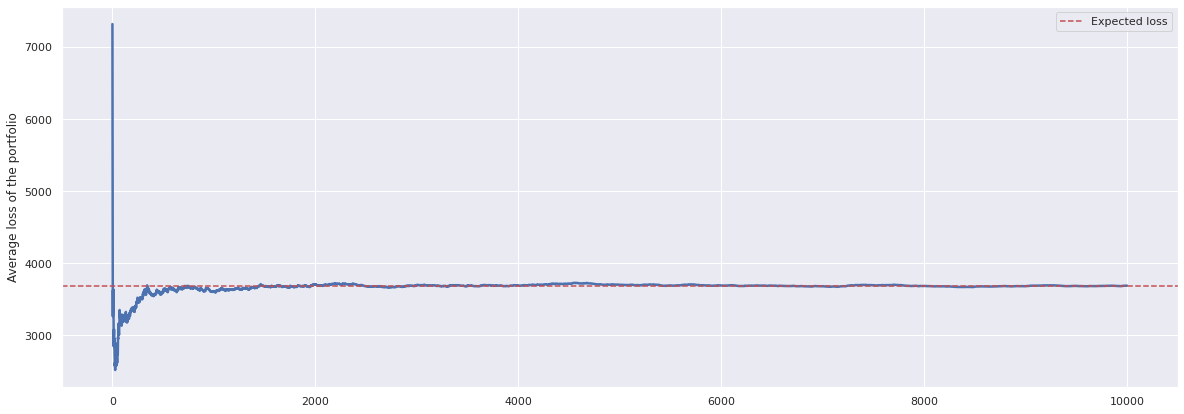

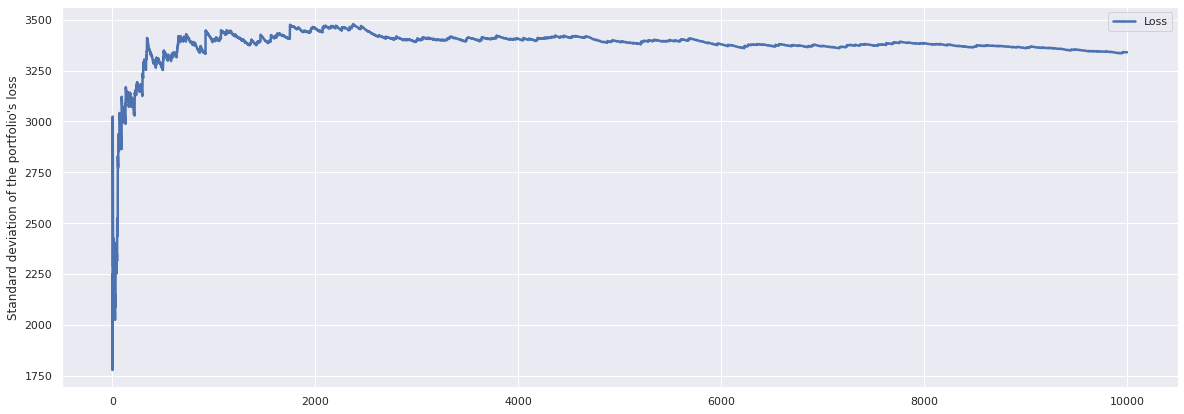

In [119]:
def plot_average_loss(simu_loss,EL):
  cum_loss_mean=simu_loss.expanding().mean()
  cum_loss_std=simu_loss.expanding().std()

  # We plot the average loss of the portfolio as a function of the number of simulations
  sns.set(rc={'figure.figsize':(20, 7)})
  ploted_mean = cum_loss_mean.plot(color='b',linewidth=2.5)
  a=ploted_mean.axhline(EL, color='r', linestyle='--')
  ploted_mean.set_ylabel('Average loss of the portfolio')
  ploted_mean.legend([a],['Expected loss'])

  sns.set(rc={'figure.figsize':(20, 7)})
  ploted_std = cum_loss_std.plot(color='b',linewidth=2.5)
  ploted_std.set_ylabel("Standard deviation of the portfolio's loss")

plot_average_loss(simu_loss,EL)

#**CDO Slice**

In [120]:
simu_loss_cdo=simu_loss/total_exposure *100 #This is the loss of the portofolio in percentage

simu_loss_cdo

,Loss
0,4.747622
1,2.684262
2,2.823757
3,0.334890
4,0.000000
...,...
9995,5.350740
9996,0.994388
9997,5.218972
9998,7.894365


In [121]:
sliced=(simu_loss_cdo-strike > 0)* (simu_loss_cdo-strike) # We compute max(portfolio_loss,0)
sliced=(sliced>size)*size + (sliced<size)*sliced #We compute min(sliced,size)

sliced

,Loss
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
9995,0.000000
9996,0.000000
9997,0.000000
9998,0.894365


In [122]:
sliced_100=sliced/size *100

sliced_100

,Loss
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
9995,0.000000
9996,0.000000
9997,0.000000
9998,44.718232


In [123]:
price= sliced_100.mean()*total_exposure*size/(100*100) #We calculate the price

price

Loss    81.013022
dtype: float64

In [124]:
def calculate_price(simu_loss,strike,size):
  simu_loss_cdo=simu_loss/total_exposure *100 #This is the loss of the portofolio in percentage
  sliced=(simu_loss_cdo-strike > 0)* (simu_loss_cdo-strike) # We compute max(portfolio_loss,0)
  sliced=(sliced>size)*size + (sliced<size)*sliced #We compute min(sliced,size)
  sliced_100=sliced/size *100
  price= sliced_100.mean()*total_exposure*size/(100*100) #We calculate the price

  return price

price=calculate_price(simu_loss,strike,size)
price

Loss    81.013022
dtype: float64

#**graphic interface**

In [125]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
from termcolor import colored

In [126]:
#This function computes all the previous code with new parameters
def f(rho,rho1,rho2,rho3,rho4,rho5,window,IC,strike,size,N_simu,N_companies=N_companies):
    rhos=[rho1,rho2,rho3,rho4,rho5]
    simu_mc=monte_carlo(N_simu,N_companies)
    simu_zi=calculate_zi(simu_mc,rho,rhos,N_simu,N_companies)
    simu_loss=calculate_loss(simu_zi,window,N_simu,N_companies)
    VaR,EL,ES =calculate_indicators(simu_loss,IC,window)

    plot_average_loss(simu_loss,EL)
    price=calculate_price(simu_loss,strike,size)

    print(colored('-------------Portofolio management-------------','green'))
    print(colored('VaR : ' + str(round(VaR,1)),'red'))
    print(colored('Expected loss : ' + str(round(EL,1)),'red'))
    print(colored('Expected ShortFall : '+str(round(ES,1)),'red'))
    print(colored('--------------Credit derivatives---------------','green'))
    print(colored('Price : '+str(round(ES,1)),'red'))

def show_portfolio(boolean):
  if boolean : display(df_portfolio.head(10))
  

#We use an interact_manual widget to modify the parameters

interact_manual(f, rho=FloatSlider(min=0, max=1, step=1e-2),
                rho1=FloatSlider(min=0, max=1, step=1e-2),
                rho2=FloatSlider(min=0, max=1, step=1e-2),
                rho3=FloatSlider(min=0, max=1, step=1e-2),
                rho4=FloatSlider(min=0, max=1, step=1e-2),
                rho5=FloatSlider(min=0, max=1, step=1e-2),
                window=['1Y','3Y','5Y'],IC=[0.90,0.95,0.99],strike=widgets.IntSlider(min=0, max=100, step=1, value=100),size=widgets.IntSlider(min=0, max=100, step=1, value=100),N_simu=(0,50000,1000),N_companies=fixed(N_companies))

interactive(show_portfolio,boolean=widgets.ToggleButton(
    value=False,
    description='Show portfolio',
    disabled=False,
    button_style='', 
    tooltip='Description',
    icon='check'
))

interactive(children=(FloatSlider(value=0.0, description='rho', max=1.0, step=0.01), FloatSlider(value=0.0, de…

interactive(children=(ToggleButton(value=False, description='Show portfolio', icon='check', tooltip='Descripti…